In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
filename = 'dolphins.gml'
G_dolphins = nx.read_gml(filename)
B_dolphins = nx.modularity_matrix(G_dolphins)

In [3]:
B_dolphins.shape

(62, 62)

In [4]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [5]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.2)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.2)(reconstructed)
        return encoder,reconstructed

In [6]:
learning_rate = 1e-3

In [7]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=32,in_layers=62)
model2=AE(hidden_layers=16,in_layers=32)
model3=AE(hidden_layers=8,in_layers=16)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=62, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=62, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=16, out_features=8, bias=True)
  (encoder_output_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_output_layer): Linear(in_features=8, out_features=16, bias=True)
)


In [8]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [9]:
B_dolphins=np.asarray(B_dolphins,dtype=np.float64)
inputs=torch.from_numpy(B_dolphins)
targets=torch.from_numpy(B_dolphins)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(200,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(200,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
# print(encoder.detach().shape)

epoch : 1/200, recon loss = 0.08190910
epoch : 2/200, recon loss = 0.08058026
epoch : 3/200, recon loss = 0.07933892
epoch : 4/200, recon loss = 0.07817689
epoch : 5/200, recon loss = 0.07708688
epoch : 6/200, recon loss = 0.07606152
epoch : 7/200, recon loss = 0.07509337
epoch : 8/200, recon loss = 0.07417512
epoch : 9/200, recon loss = 0.07329979
epoch : 10/200, recon loss = 0.07246089
epoch : 11/200, recon loss = 0.07165248
epoch : 12/200, recon loss = 0.07086925
epoch : 13/200, recon loss = 0.07010650
epoch : 14/200, recon loss = 0.06936008
epoch : 15/200, recon loss = 0.06862648
epoch : 16/200, recon loss = 0.06790274
epoch : 17/200, recon loss = 0.06718653
epoch : 18/200, recon loss = 0.06647613
epoch : 19/200, recon loss = 0.06577047
epoch : 20/200, recon loss = 0.06506906
epoch : 21/200, recon loss = 0.06437198
epoch : 22/200, recon loss = 0.06367978
epoch : 23/200, recon loss = 0.06299341
epoch : 24/200, recon loss = 0.06231410
epoch : 25/200, recon loss = 0.06164323
epoch : 2

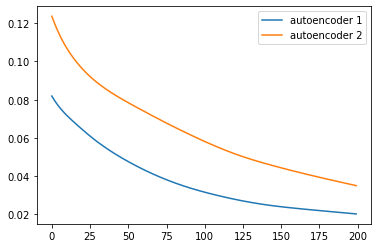

In [10]:
plt.plot(hist1,label='autoencoder 1')
plt.plot(hist2,label='autoencoder 2')
plt.legend()
plt.show()

In [11]:
B_dolphins_X=encoder.detach().numpy()

In [12]:
print(type(B_dolphins_X),B_dolphins_X)

<class 'numpy.ndarray'> [[ 0.52457     0.10483092 -0.62833536  0.56765956 -0.19564405 -0.0773651
  -0.0336651  -0.41553473  0.3258025   0.5577012   0.3038937  -0.2693932
   0.06163228  0.67545074 -0.19405018 -0.29769975]
 [-0.15002482 -0.2774286   0.13398087  0.04157382 -0.34557307 -0.43571416
   0.48257968 -0.34655195 -0.13426344 -0.37336913  0.42288014  0.26968828
   0.01070231 -0.78588873  0.09497951 -0.00118229]
 [ 0.47559842 -0.108787   -0.327191    0.51198417 -0.22282217 -0.16932066
  -0.12781271 -0.2766386   0.2490192   0.00759873  0.3650399   0.13169587
  -0.21684815  0.5065798   0.30981123 -0.6438399 ]
 [ 0.10651786  0.3082395  -0.4470037   0.2066444  -0.30014127 -0.18901424
   0.3089723  -0.06233803 -0.04274343  0.24926116  0.36249655  0.1511031
   0.02081287  0.20394391 -0.3228738   0.13523468]
 [ 0.16910125  0.20972556  0.05593361  0.363245   -0.41381973 -0.23917443
   0.27243826 -0.04282703  0.04718505 -0.21524148  0.23813817  0.02858049
  -0.19948587 -0.0787803  -0.138874

In [16]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=892)
kmeans.fit(B_dolphins_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_dolphins,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[1 2 1 3 0 2 2 2 0 2 1 0 3 2 3 1 3 2 0 2 3 0 2 0 0 0 2 2 2 0 1 2 2 3 3 0 3
 3 3 3 3 2 1 3 3 0 2 1 2 3 3 0 3 2 2 0 2 2 3 0 2 3]
[1 0 1 2 3 0 0 0 2 0 1 3 2 0 2 3 2 0 3 0 2 3 0 3 3 0 0 0 1 3 1 0 0 2 2 3 2
 2 2 2 2 0 1 2 2 3 2 1 0 2 2 3 2 2 0 3 0 0 2 2 0 2]


0.7131292528998613

In [15]:
max=0
index_max=0
for value in range(1,00):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_dolphins_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_dolphins,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.5751723250197979
Epoch:2 1 0.5751723250197979
Epoch:3 1 0.5751723250197979
Epoch:4 1 0.5751723250197979
Epoch:5 1 0.5751723250197979
Epoch:6 1 0.5751723250197979
Epoch:7 1 0.5751723250197979
Epoch:8 1 0.5751723250197979
Epoch:9 1 0.5751723250197979
Epoch:10 1 0.5751723250197979
Epoch:11 1 0.5751723250197979
Epoch:12 1 0.5751723250197979
Epoch:13 1 0.5751723250197979
Epoch:14 1 0.5751723250197979
Epoch:15 1 0.5751723250197979
Epoch:16 1 0.5751723250197979
Epoch:17 1 0.5751723250197979
Epoch:18 1 0.5751723250197979
Epoch:19 1 0.5751723250197979
Epoch:20 1 0.5751723250197979
Epoch:21 1 0.5751723250197979
Epoch:22 1 0.5751723250197979
Epoch:23 1 0.5751723250197979
Epoch:24 1 0.5751723250197979
Epoch:25 1 0.5751723250197979
Epoch:26 1 0.5751723250197979
Epoch:27 1 0.5751723250197979
Epoch:28 1 0.5751723250197979
Epoch:29 1 0.5751723250197979
Epoch:30 1 0.5751723250197979
Epoch:31 1 0.5751723250197979
Epoch:32 1 0.5751723250197979
Epoch:33 1 0.5751723250197979
Epoch:34 1 0.575172

In [17]:
G=G_dolphins
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=892)
kmeans.fit(B_dolphins_X)
X_ae = kmeans.labels_
labels_dict={0:[],1:[],2:[],3:[]}
for index,item in enumerate(X_ae):
    labels_dict[item].append(list(G.nodes)[index])
print(labels_dict)

{0: ['Cross', 'Double', 'Five', 'Jonah', 'MN105', 'MN60', 'MN83', 'Mus', 'Patchback', 'SMN5', 'Topless', 'Trigger', 'Vau', 'Zap'], 1: ['Beak', 'Bumper', 'Fish', 'Haecksel', 'PL', 'SN96', 'TR77'], 2: ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Notch', 'Number1', 'Oscar', 'Quasi', 'Ripplefluke', 'SN90', 'TR120', 'TR82', 'TSN83', 'Upbang', 'Wave', 'Web', 'Zig'], 3: ['CCL', 'Fork', 'Grin', 'Hook', 'Kringel', 'Scabs', 'Shmuddel', 'SN100', 'SN4', 'SN63', 'SN89', 'SN9', 'Stripes', 'Thumper', 'TR88', 'TR99', 'TSN103', 'Whitetip', 'Zipfel']}


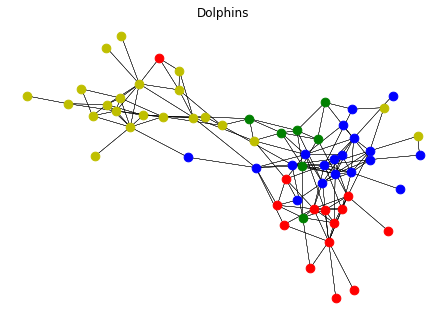

In [18]:
G=G_dolphins
pos=nx.spring_layout(G)
nx.draw(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75,width=0.25)
nx.draw(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75,width=0.25)
nx.draw(G,pos,nodelist=labels_dict[2],node_color='y',node_size=75,width=0.25)
nx.draw(G,pos,nodelist=labels_dict[3],node_color='b',node_size=75,width=0.25)

plt.title('Dolphins')
plt.show()